In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from sklearn.cluster import AgglomerativeClustering

## DW vs Adaptive DW

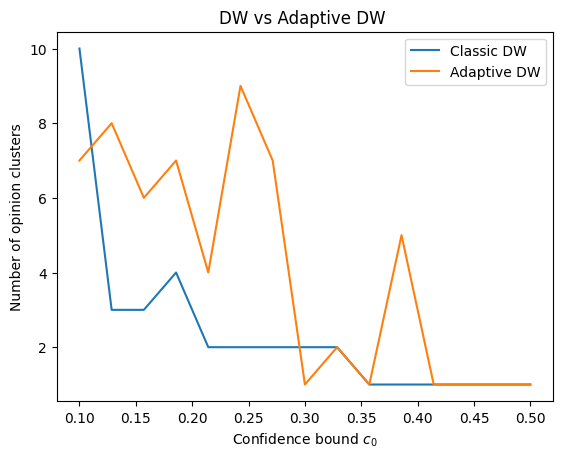

In [ ]:
def simulate_dw(G, opinions, epsilon, mu, steps):
    opinions = opinions.copy()
    for _ in range(steps):
        i,j = random.choice(list(G.edges))
        if abs(opinions[i] - opinions[j]) < epsilon:
            xi, xj = opinions[i], opinions[j]
            opinions[i] += mu * (xj - xi)
            opinions[j] += mu * (xi - xj)
    return opinions

def simulate_adaptive_dw(G, opinions, epsilon, mu, gamma, delta, steps):
    opinions = opinions.copy()
    c = {edge: epsilon for edge in G.edges}
    for _ in range(steps):
        i,j = random.choice(list(G.edges))
        diff = abs(opinions[i] - opinions[j])
        if diff < c[(i,j)]:
            xi, xj = opinions[i], opinions[j]
            opinions[i] += mu * (xj - xi)
            opinions[j] += mu * (xi - xj)
            c[(i,j)] = min(1, c[(i,j)] + gamma)
        else:
            c[(i,j)] = max(0, c[(i,j)] - delta)
        if diff > c[(i,j)]:
            possible = [u for u in G.nodes if u not in G[i]]
            if possible:
                G.remove_edge(i,j)
                k = random.choice(possible)
                G.add_edge(i,k); c[(i,k)] = c[(i,j)]
    return opinions

def count_clusters(opinions, eps=1e-2):
    X = opinions.reshape(-1,1)
    clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=eps).fit(X)
    labels, counts = np.unique(clustering.labels_, return_counts=True)
    return np.sum(counts > 1)

N = 100; mu = 0.5; steps = 5000; gamma = 0.1; delta = 0.1
confs = np.linspace(0.1,0.5,15)
results = {'DW':[], 'Adaptive':[]}
G0 = nx.complete_graph(N)

for c0 in confs:
    base = simulate_dw(G0.copy(), np.random.rand(N), c0, mu, steps)
    results['DW'].append(count_clusters(base))
    adp = simulate_adaptive_dw(G0.copy(), np.random.rand(N), c0, mu, gamma, delta, steps)
    results['Adaptive'].append(count_clusters(adp))

plt.plot(confs, results['DW'], label='Classic DW')
plt.plot(confs, results['Adaptive'], label='Adaptive DW')
plt.xlabel('Confidence bound $c_0$')
plt.ylabel('Number of opinion clusters')
plt.legend()
plt.title('DW vs Adaptive DW ')
plt.show()


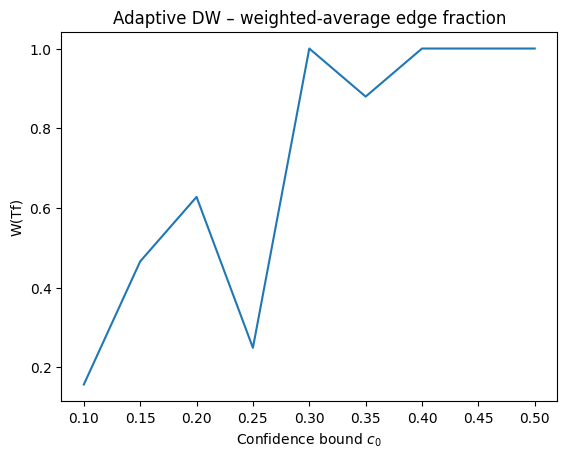

In [2]:
def compute_W(G, opinions, eps=1e-2):
    from sklearn.cluster import AgglomerativeClustering
    labels = AgglomerativeClustering(n_clusters=None, distance_threshold=eps).fit(opinions.reshape(-1,1)).labels_
    edges = G.edges()
    same = sum(1 for i,j in edges if labels[i]==labels[j])
    return same / G.number_of_edges()

Ws = []
for c0 in confs:
    G1 = nx.complete_graph(N)
    opin = simulate_adaptive_dw(G1, np.random.rand(N), c0, mu, gamma, delta, steps)
    Ws.append(compute_W(G1, opin))
plt.plot(confs, Ws)
plt.xlabel('Confidence bound $c_0$')
plt.ylabel('W(Tf)')
plt.title('Adaptive DW – weighted-average edge fraction')
plt.show()


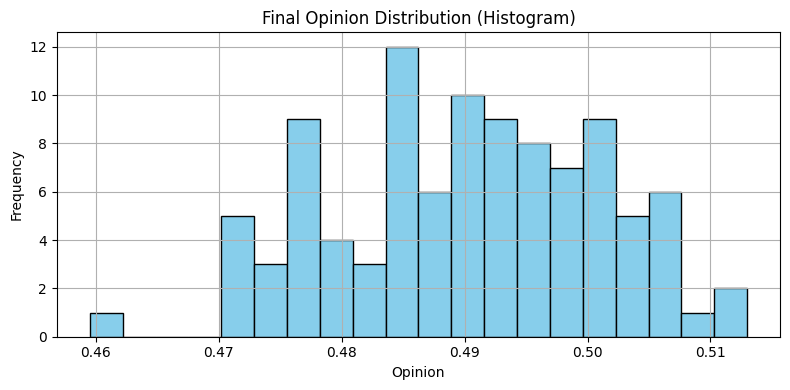

'adaptive_dw_animation.gif'

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import imageio

N = 100
mu = 0.5
gamma = 0.1
delta = 0.1
steps = 3000
epsilon = 0.3

G = nx.watts_strogatz_graph(N, k=6, p=0.1)
opinions = np.random.rand(N)
c = {tuple(sorted(edge)): epsilon for edge in G.edges}

frames = []
opinion_history = [opinions.copy()]
pos = nx.spring_layout(G, seed=42)

for step in range(steps):
    i, j = random.choice(list(G.edges))
    edge = tuple(sorted((i, j)))
    diff = abs(opinions[i] - opinions[j])
    if diff < c[edge]:
        xi, xj = opinions[i], opinions[j]
        opinions[i] += mu * (xj - xi)
        opinions[j] += mu * (xi - xj)
        c[edge] = min(1, c[edge] + gamma)
    else:
        c[edge] = max(0, c[edge] - delta)
        possible = [u for u in G.nodes if u not in G[i] and u != i]
        if possible:
            G.remove_edge(i, j)
            k = random.choice(possible)
            G.add_edge(i, k)
            new_edge = tuple(sorted((i, k)))
            c[new_edge] = epsilon

    if step % 100 == 0:
        opinion_history.append(opinions.copy())
        node_colors = [opinions[n] for n in G.nodes]
        fig, ax = plt.subplots(figsize=(6, 6))
        nx.draw(G, pos, node_color=node_colors, cmap=plt.cm.viridis, node_size=50, ax=ax)
        ax.set_title(f"Step {step}")
        ax.axis('off')
        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)
        plt.close(fig)

final_opinions = opinion_history[-1]
plt.figure(figsize=(8, 4))
plt.hist(final_opinions, bins=20, color='skyblue', edgecolor='black')
plt.title("Final Opinion Distribution (Histogram)")
plt.xlabel("Opinion")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

gif_path = "adaptive_dw_animation.gif"
imageio.mimsave(gif_path, frames, fps=5)
gif_path

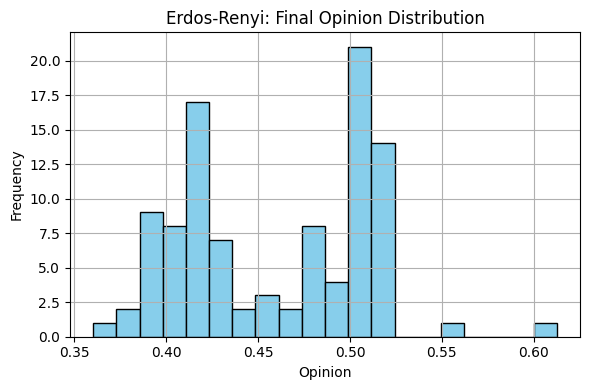

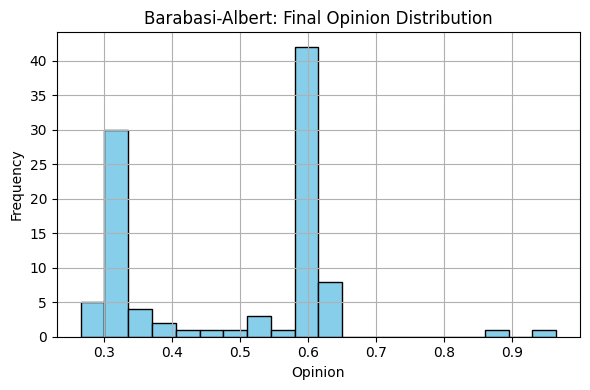

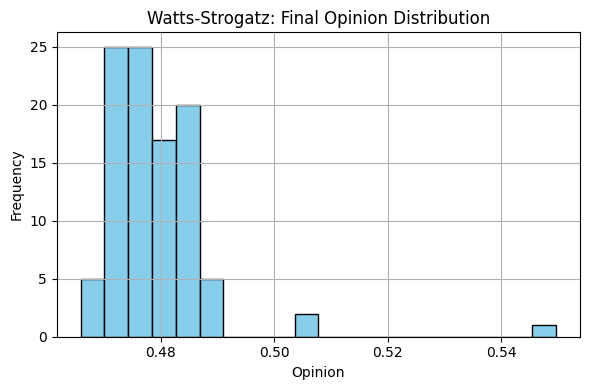

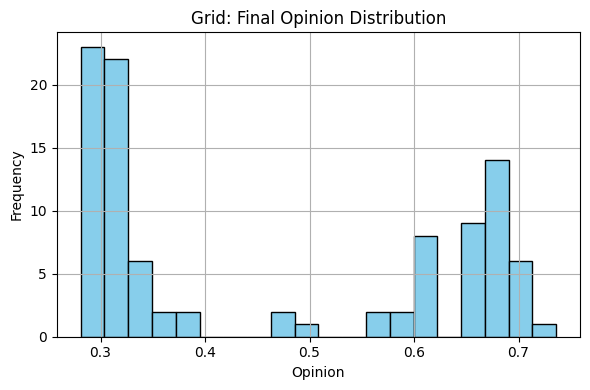

{'Erdos-Renyi': 5, 'Barabasi-Albert': 10, 'Watts-Strogatz': 2, 'Grid': 8}

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from collections import defaultdict

N = 100
mu = 0.5
gamma = 0.1
delta = 0.1
epsilon = 0.3
steps = 3000
snapshot_interval = 100

network_types = {
    "Erdos-Renyi": nx.erdos_renyi_graph(N, 0.05),
    "Barabasi-Albert": nx.barabasi_albert_graph(N, 3),
    "Watts-Strogatz": nx.watts_strogatz_graph(N, 6, 0.1),
    "Grid": nx.convert_node_labels_to_integers(nx.grid_2d_graph(10, 10))
}

final_opinions_by_type = {}
cluster_counts = {}

def simulate_adaptive_dw(G, opinions, steps, mu, gamma, delta, epsilon):
    c = {tuple(sorted(edge)): epsilon for edge in G.edges}
    for step in range(steps):
        if len(G.edges) == 0:
            break
        i, j = random.choice(list(G.edges))
        edge = tuple(sorted((i, j)))
        diff = abs(opinions[i] - opinions[j])
        if diff < c[edge]:
            xi, xj = opinions[i], opinions[j]
            opinions[i] += mu * (xj - xi)
            opinions[j] += mu * (xi - xj)
            c[edge] = min(1, c[edge] + gamma)
        else:
            c[edge] = max(0, c[edge] - delta)
            possible = [u for u in G.nodes if u not in G[i] and u != i]
            if possible:
                G.remove_edge(i, j)
                k = random.choice(possible)
                G.add_edge(i, k)
                new_edge = tuple(sorted((i, k)))
                c[new_edge] = epsilon
    return opinions

for name, G in network_types.items():
    G = nx.convert_node_labels_to_integers(G)
    opinions = np.random.rand(len(G))
    final_opinions = simulate_adaptive_dw(G, opinions.copy(), steps, mu, gamma, delta, epsilon)
    final_opinions_by_type[name] = final_opinions

    bins = np.histogram(final_opinions, bins=np.arange(0, 1.01, 0.05))[0]
    num_clusters = np.sum(bins > 0)
    cluster_counts[name] = num_clusters

    plt.figure(figsize=(6, 4))
    plt.hist(final_opinions, bins=20, color='skyblue', edgecolor='black')
    plt.title(f"{name}: Final Opinion Distribution")
    plt.xlabel("Opinion")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

cluster_counts

### Dodanie noise - jako rozszerzenie


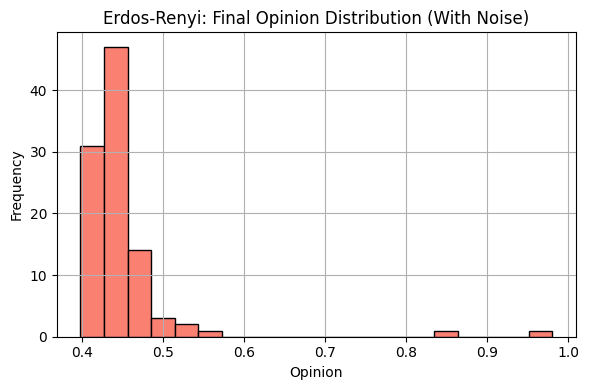

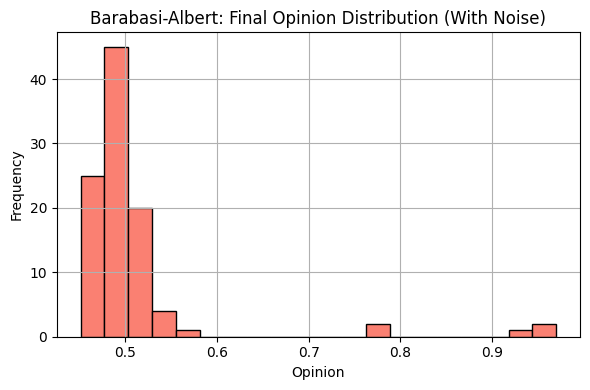

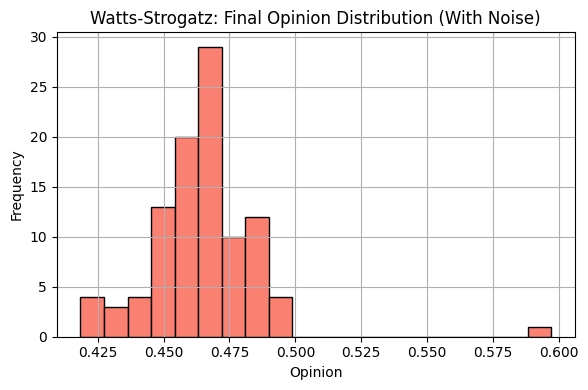

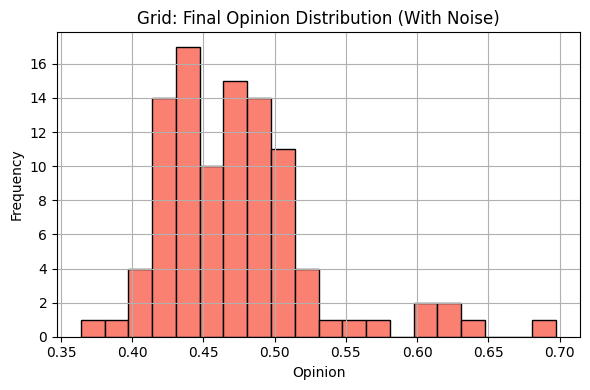

{'Erdos-Renyi': 7, 'Barabasi-Albert': 6, 'Watts-Strogatz': 3, 'Grid': 7}

In [ ]:
N = 100
mu = 0.5
gamma = 0.1
delta = 0.1
epsilon = 0.3
steps = 3000
sigma = 0.02

network_types = {
    "Erdos-Renyi": nx.erdos_renyi_graph(N, 0.05),
    "Barabasi-Albert": nx.barabasi_albert_graph(N, 3),
    "Watts-Strogatz": nx.watts_strogatz_graph(N, 6, 0.1),
    "Grid": nx.convert_node_labels_to_integers(nx.grid_2d_graph(10, 10))
}

def simulate_adaptive_dw_with_noise(G, opinions, steps, mu, gamma, delta, epsilon, sigma=0.02):
    c = {tuple(sorted(edge)): epsilon for edge in G.edges}
    for step in range(steps):
        if len(G.edges) == 0:
            break
        i, j = random.choice(list(G.edges))
        edge = tuple(sorted((i, j)))
        diff = abs(opinions[i] - opinions[j])
        if diff < c[edge]:
            xi, xj = opinions[i], opinions[j]
            eta_i = np.random.uniform(-sigma, sigma)
            eta_j = np.random.uniform(-sigma, sigma)
            opinions[i] = np.clip(xi + mu * (xj - xi) + eta_i, 0, 1)
            opinions[j] = np.clip(xj + mu * (xi - xj) + eta_j, 0, 1)
            c[edge] = min(1, c[edge] + gamma)
        else:
            c[edge] = max(0, c[edge] - delta)
            possible = [u for u in G.nodes if u not in G[i] and u != i]
            if possible:
                G.remove_edge(i, j)
                k = random.choice(possible)
                G.add_edge(i, k)
                new_edge = tuple(sorted((i, k)))
                c[new_edge] = epsilon
    return opinions

final_opinions_noise_by_type = {}
cluster_counts_noise = {}

for name, G in network_types.items():
    G = nx.convert_node_labels_to_integers(G)
    opinions = np.random.rand(len(G))
    final_opinions = simulate_adaptive_dw_with_noise(G, opinions.copy(), steps, mu, gamma, delta, epsilon, sigma)
    final_opinions_noise_by_type[name] = final_opinions

    bins = np.histogram(final_opinions, bins=np.arange(0, 1.01, 0.05))[0]
    num_clusters = np.sum(bins > 0)
    cluster_counts_noise[name] = num_clusters

    plt.figure(figsize=(6, 4))
    plt.hist(final_opinions, bins=20, color='salmon', edgecolor='black')
    plt.title(f"{name}: Final Opinion Distribution (With Noise)")
    plt.xlabel("Opinion")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig(f"histogram_noise.png")
    #plt.close()
    plt.show()

cluster_counts_noise


### Gif

In [25]:
def simulate_and_create_gif(network_name, G, steps=3000, sigma=0.02):
    mu = 0.5
    gamma = 0.1
    delta = 0.1
    epsilon = 0.3

    G = nx.convert_node_labels_to_integers(G)
    opinions = np.random.rand(len(G))
    c = {tuple(sorted(edge)): epsilon for edge in G.edges}
    frames = []
    pos = nx.spring_layout(G, seed=42)

    for step in range(steps):
        if len(G.edges) == 0:
            break
        i, j = random.choice(list(G.edges))
        edge = tuple(sorted((i, j)))
        diff = abs(opinions[i] - opinions[j])
        if diff < c[edge]:
            xi, xj = opinions[i], opinions[j]
            eta_i = np.random.uniform(-sigma, sigma)
            eta_j = np.random.uniform(-sigma, sigma)
            opinions[i] = np.clip(xi + mu * (xj - xi) + eta_i, 0, 1)
            opinions[j] = np.clip(xj + mu * (xi - xj) + eta_j, 0, 1)
            c[edge] = min(1, c[edge] + gamma)
        else:
            c[edge] = max(0, c[edge] - delta)
            possible = [u for u in G.nodes if u not in G[i] and u != i]
            if possible:
                G.remove_edge(i, j)
                k = random.choice(possible)
                G.add_edge(i, k)
                new_edge = tuple(sorted((i, k)))
                c[new_edge] = epsilon

        if step % 100 == 0:
            node_colors = [opinions[n] for n in G.nodes]
            fig, ax = plt.subplots(figsize=(6, 6))
            nx.draw(G, pos, node_color=node_colors, cmap=plt.cm.viridis, node_size=50, ax=ax)
            ax.set_title(f"{network_name} - Step {step}")
            ax.axis('off')
            fig.canvas.draw()
            frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            frames.append(frame)
            plt.close(fig)

    gif_path = f"{network_name.lower().replace(' ', '_')}_dw_noise.gif"
    imageio.mimsave(gif_path, frames, fps=5)
    return gif_path

G_er = nx.erdos_renyi_graph(100, 0.05)
G_ba = nx.barabasi_albert_graph(100, 3)
G_ws = nx.watts_strogatz_graph(100, k=6, p=0.1)

gif_er = simulate_and_create_gif("Erdos-Renyi", G_er)
gif_ba = simulate_and_create_gif("Barabasi-Albert", G_ba)
gif_ws = simulate_and_create_gif("Watts_Strogatz", G_ws)


gif_er, gif_ba


('erdos-renyi_dw_noise.gif', 'barabasi-albert_dw_noise.gif')

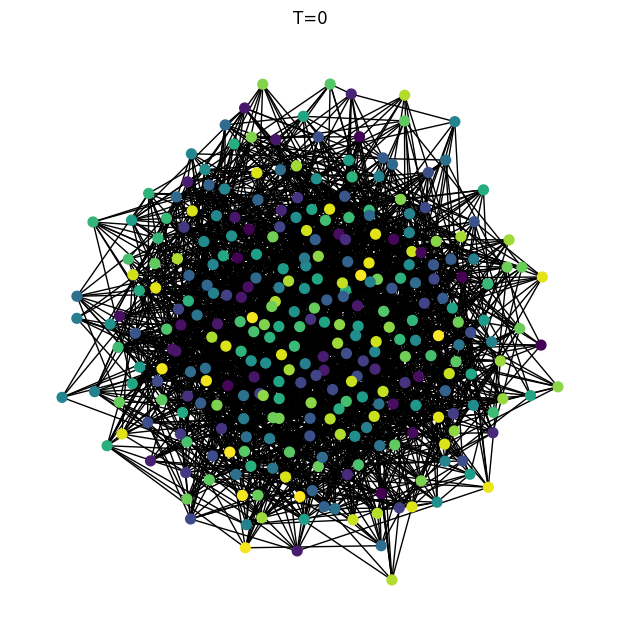

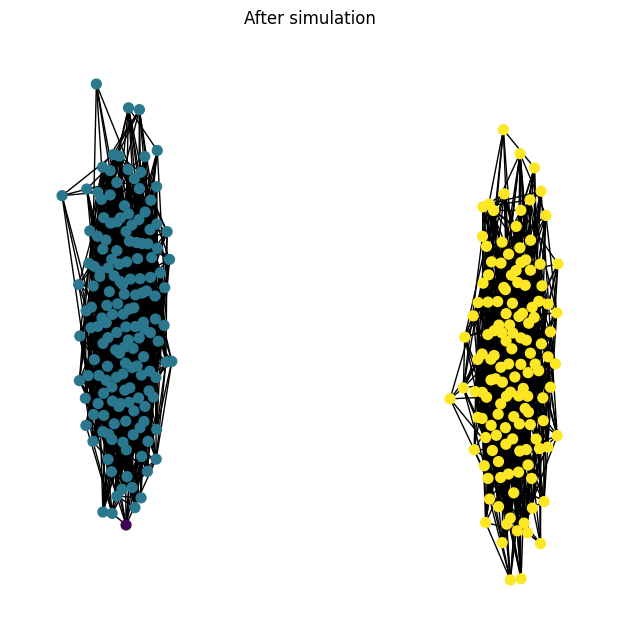

In [23]:
N = 300                  
p = 0.05                 
M = 10                  
K = 20                  
epsilon = 0.32           
C = 0.24                
mu = 0.5                 
bail_out_time = 1000
tolerance = 1e-4

G = nx.erdos_renyi_graph(N, p)
opinions = np.random.rand(N)
t = 0
no_change_steps = 0

opinion_history = [opinions.copy()]
discordant_edge_count = []

plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_color=opinions, cmap='viridis', node_size=50)
plt.title("T=0")
plt.show()

while t < bail_out_time and no_change_steps < 100:
    opinions_old = opinions.copy()

    discordant_edges = []
    for (i, j) in G.edges():
        if abs(opinions[i] - opinions[j]) >= epsilon:
            discordant_edges.append((i, j))

    if len(discordant_edges) > M:
        discordant_edges = random.sample(discordant_edges, M)

    for (i, j) in discordant_edges:
        if G.has_edge(i, j):
            G.remove_edge(i, j)
        chosen = random.choice([i, j])
        probs = []
        nodes = list(G.nodes())
        for node in nodes:
            if node != chosen and not G.has_edge(chosen, node):
                d = abs(opinions[chosen] - opinions[node])
                probs.append(1 - d)
            else:
                probs.append(0)
        probs = np.array(probs)
        if probs.sum() > 0:
            probs /= probs.sum()
            new_node = np.random.choice(nodes, p=probs)
            G.add_edge(chosen, new_node)

    if len(G.edges) == 0:
        break
    selected_edges = random.sample(list(G.edges), min(K, len(G.edges)))
    for (i, j) in selected_edges:
        if abs(opinions[i] - opinions[j]) < C:
            xi, xj = opinions[i], opinions[j]
            opinions[i] = xi + mu * (xj - xi)
            opinions[j] = xj + mu * (xi - xj)

    total_change = np.sum(np.abs(opinions - opinions_old))
    if total_change < tolerance:
        no_change_steps += 1
    else:
        no_change_steps = 0

    t += 1
    opinion_history.append(opinions.copy())
    discordant_edge_count.append(len(discordant_edges))

final_opinions = opinion_history[-1]

plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_color=final_opinions, cmap='viridis', node_size=50)
plt.title("After simulation")
plt.show()




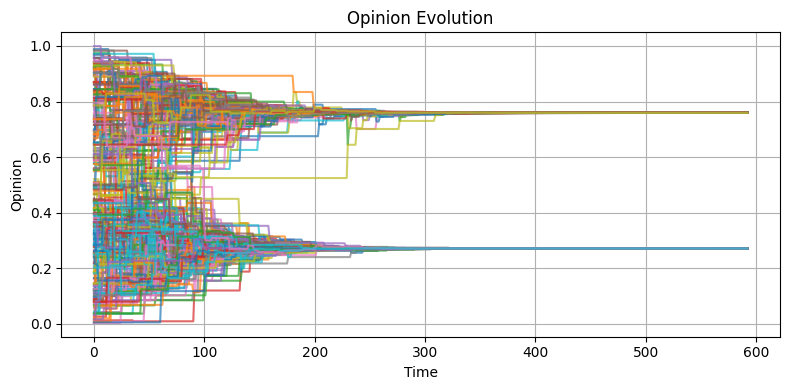

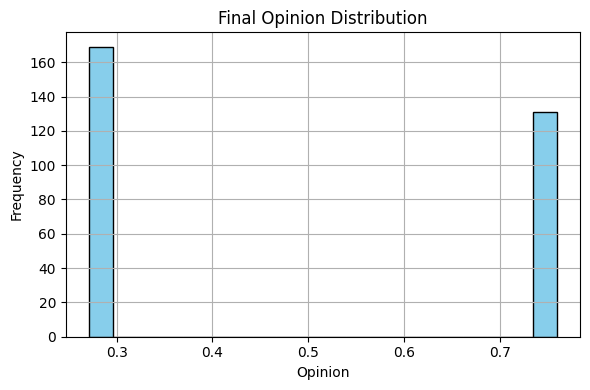

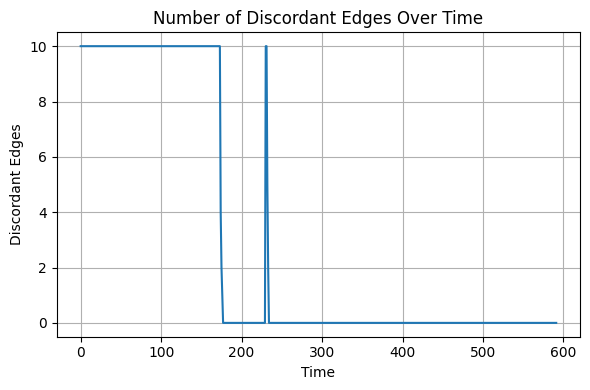

In [22]:
plt.figure(figsize=(8, 4))
for i in range(N):
    plt.plot([o[i] for o in opinion_history], alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Opinion")
plt.title("Opinion Evolution")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(final_opinions, bins=20, color='skyblue', edgecolor='black')
plt.title("Final Opinion Distribution")
plt.xlabel("Opinion")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(discordant_edge_count)
plt.title("Number of Discordant Edges Over Time")
plt.xlabel("Time")
plt.ylabel("Discordant Edges")
plt.grid(True)
plt.tight_layout()
plt.show()


### Clusters - threshold and epsilon

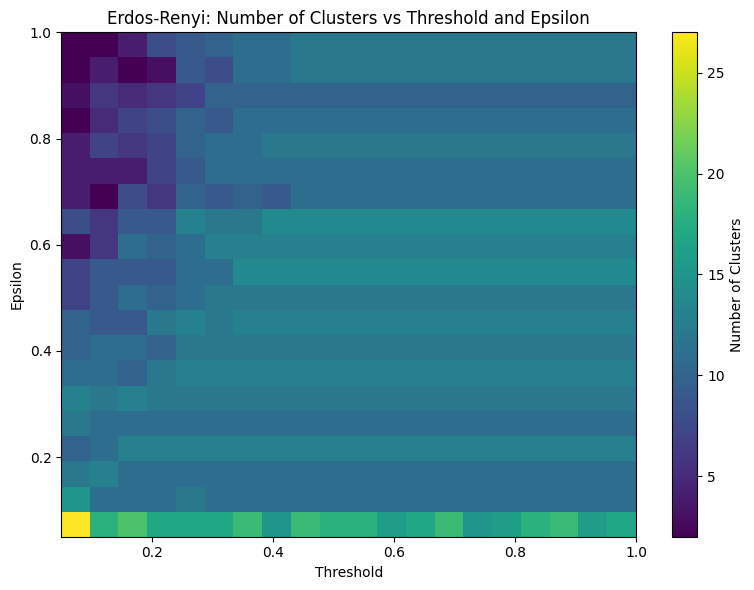

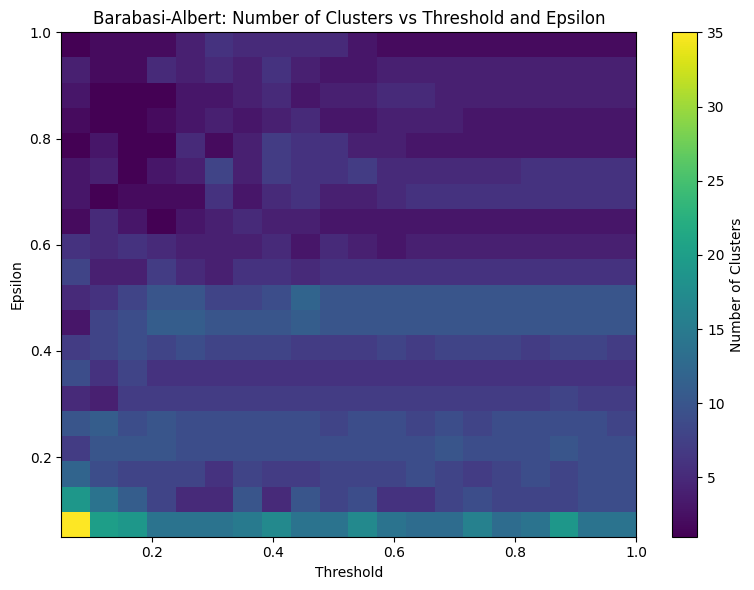

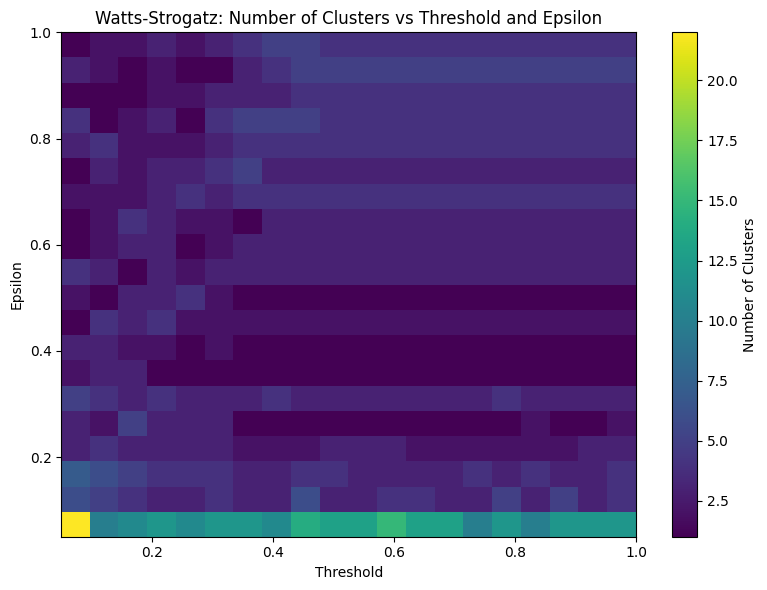

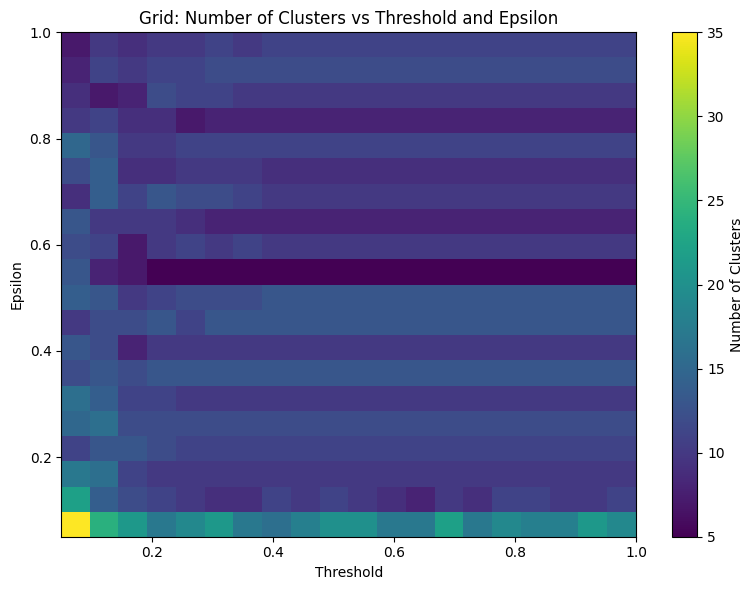

Network type: Erdos-Renyi
Threshold: 0.05, Epsilon: 0.05, Number of clusters: 27
Threshold: 0.05, Epsilon: 0.10, Number of clusters: 18
Threshold: 0.05, Epsilon: 0.15, Number of clusters: 20
Threshold: 0.05, Epsilon: 0.20, Number of clusters: 17
Threshold: 0.05, Epsilon: 0.25, Number of clusters: 17
Threshold: 0.05, Epsilon: 0.30, Number of clusters: 17
Threshold: 0.05, Epsilon: 0.35, Number of clusters: 19
Threshold: 0.05, Epsilon: 0.40, Number of clusters: 15
Threshold: 0.05, Epsilon: 0.45, Number of clusters: 19
Threshold: 0.05, Epsilon: 0.50, Number of clusters: 18
Threshold: 0.05, Epsilon: 0.55, Number of clusters: 18
Threshold: 0.05, Epsilon: 0.60, Number of clusters: 16
Threshold: 0.05, Epsilon: 0.65, Number of clusters: 17
Threshold: 0.05, Epsilon: 0.70, Number of clusters: 19
Threshold: 0.05, Epsilon: 0.75, Number of clusters: 15
Threshold: 0.05, Epsilon: 0.80, Number of clusters: 16
Threshold: 0.05, Epsilon: 0.85, Number of clusters: 18
Threshold: 0.05, Epsilon: 0.90, Number 

In [28]:
def simulate_adaptive_dw_with_clustering(G, opinions, steps, mu, gamma, delta, epsilon, threshold):
    c = {tuple(sorted(edge)): epsilon for edge in G.edges}
    for step in range(steps):
        if len(G.edges) == 0:
            break
        i, j = random.choice(list(G.edges))
        edge = tuple(sorted((i, j)))
        diff = abs(opinions[i] - opinions[j])
        if diff < c[edge]:
            xi, xj = opinions[i], opinions[j]
            opinions[i] += mu * (xj - xi)
            opinions[j] += mu * (xi - xj)
            c[edge] = min(1, c[edge] + gamma)
        else:
            c[edge] = max(0, c[edge] - delta)
            possible = [u for u in G.nodes if u not in G[i] and u != i]
            if possible:
                G.remove_edge(i, j)
                k = random.choice(possible)
                G.add_edge(i, k)
                new_edge = tuple(sorted((i, k)))
                c[new_edge] = epsilon

    cluster_graph = nx.Graph()
    cluster_graph.add_nodes_from(G.nodes)

    for i, j in G.edges:
        if abs(opinions[i] - opinions[j]) < threshold:  
            cluster_graph.add_edge(i, j)

    clusters = list(nx.connected_components(cluster_graph))
    return opinions, len(clusters)


threshold_values = np.arange(0.05, 1.05, 0.05)   Different thresholds from 0.05 to 1.0
epsilon_values = np.arange(0.05, 1.05, 0.05)  
num_clusters_matrix = {}

for name, G in network_types.items():
    G = nx.convert_node_labels_to_integers(G)  
    opinions = np.random.rand(len(G))  
    clusters_for_all_combinations = []

    for threshold in threshold_values:
        clusters_for_this_threshold = []
        for epsilon in epsilon_values:
            final_opinions, num_clusters = simulate_adaptive_dw_with_clustering(
                G, opinions.copy(), steps=1000, mu=0.1, gamma=0.1, delta=0.01, epsilon=epsilon, threshold=threshold
            )
            clusters_for_this_threshold.append(num_clusters)

        clusters_for_all_combinations.append(clusters_for_this_threshold)

    num_clusters_matrix[name] = np.array(clusters_for_all_combinations)

    plt.figure(figsize=(8, 6))
    plt.imshow(num_clusters_matrix[name], cmap=cm.viridis, aspect='auto', origin='lower',
               extent=[threshold_values[0], threshold_values[-1], epsilon_values[0], epsilon_values[-1]])
    plt.colorbar(label="Number of Clusters")
    plt.title(f"{name}: Number of Clusters vs Threshold and Epsilon")
    plt.xlabel("Threshold")
    plt.ylabel("Epsilon")
    plt.tight_layout()
    plt.show()

